# Significance testing

In [9]:
import numpy as np
import pandas as pd
import os
from checkFissFus2 import get_fiss_fus_all , fiss_fus_reassigned_label
from significance_test import sliding_window_cumsum,regularization,apply_function_to_arrays,convert_to_sig_test, apply_function_folder
import matplotlib.pyplot as plt
import pingouin as pg

## import and prepare data

### import data

In [10]:
dir_path_md = "../algo_output/mdivi/adjusted_"
dir_path_md_self = "../self_event/mdivi/num_area_"
dir_raw_md = "D:/Internship/NTU/nellie_output/nellie_output/mdivi/"

In [11]:
#after area threshold adjustment
fission_tox1, fusion_tox1, fiss_frame, fus_frame = get_fiss_fus_all(dir_path_md)

#self event
fission_tox1_self, fusion_tox1_self, fiss_self1, fus_self1 = get_fiss_fus_all(dir_path_md_self)

#fission fusion from Nellie author 
out_tox1 = apply_function_folder(dir_raw_md, keywords="features_components", func=fiss_fus_reassigned_label)

### fission/fusion from Nellie's Author

In [13]:
out_tox1_copy = out_tox1.copy()
x = out_tox1.keys()

for key in x:
    condition = key.split("_")[2].split(".")[0]
    out_tox1_copy[condition] = out_tox1_copy.pop((key))

In [15]:
out_tox1_copy.keys()

dict_keys(['10min', '3'])

In [26]:
fission_tox_nellie = [out_tox1_copy["control"][2],out_tox1_copy["FCCP"][2],out_tox1_copy["oligomycin"][2],out_tox1_copy["Rotenone"][2]]
fusion_tox_nellie = [out_tox1_copy["control"][3],out_tox1_copy["FCCP"][3],out_tox1_copy["oligomycin"][3],out_tox1_copy["Rotenone"][3]]
minimum = np.min([len(x) for x in fission_tox_nellie])
fission_tox_nellie = np.array([x[0:minimum] for x in fission_tox_nellie])
fusion_tox_nellie = np.array([x[0:minimum] for x in fusion_tox_nellie])

### Area and label number

In [ ]:
minimum

(np.int64(137), np.int64(144), np.int64(139))

In [31]:
def get_label_info_old(path,max_size):
    df = pd.read_csv(path)
    mini_df = df[['t', 'label', 'area_raw' , 'solidity_raw', 'aspect_ratio_mean', 'divergence_mean' , 'convergence_mean', 'reassigned_label_raw'] ]

    frames = np.unique(mini_df['t'])
    label_num_all = []
    area_all = []
    raw_label_all = []
    frame_all = []
    for frame in frames:
        mini_df_frame = mini_df[mini_df['t'] == frame]
        label_num = len(np.unique(mini_df_frame['reassigned_label_raw']))
        area = np.sum(mini_df_frame['area_raw']) # can also do average area
        raw_label = len(np.unique(mini_df_frame['label']))
        
        if len(label_num_all) < max_size:
            label_num_all.append(label_num)
            area_all.append(area)
            raw_label_all.append(raw_label) 
            frame_all.append(frame)

    return np.array(label_num_all), np.array(area_all), np.array(raw_label_all), np.array(frame_all)

In [32]:
def get_label_info(path,max_size):
    df = pd.read_csv(path)
    mini_df = df[['t', 'label', 'organelle_area_raw' , 'organelle_solidity_raw',  'reassigned_label_raw'] ]

    frames = np.unique(mini_df['t'])
    label_num_all = []
    area_all = []
    raw_label_all = []
    frame_all = []
    for frame in frames:
        mini_df_frame = mini_df[mini_df['t'] == frame]
        label_num = len(np.unique(mini_df_frame['reassigned_label_raw']))
        area = np.sum(mini_df_frame['organelle_area_raw']) # can also do average area
        raw_label = len(np.unique(mini_df_frame['label']))
        
        if len(label_num_all) < max_size:
            label_num_all.append(label_num)
            area_all.append(area)
            raw_label_all.append(raw_label) 
            frame_all.append(frame)

    return np.array(label_num_all), np.array(area_all), np.array(raw_label_all), np.array(frame_all)

In [33]:
stream_file = ['control','FCCP','oligomycin','Rotenone']

main_dir = "D:/Internship/NTU/nellie_output/nellie_output/toxins/"
label_num_all = []
area_all = []
raw_label_all = []
frame_all = []


for s in range(len(stream_file)):
    # 1st part check area and number of label
    #im_concen = stream_con[s]
    im_concen = stream_file[s]

    #file_path_feature = main_dir + "ins1_" + im_concen + ".ome-ch0-features_components.csv"
    #file_path_feature = main_dir + "/" + im_frame + "_resized_" + im_concen + "_glu_1min_#1.ome-ch0-features_components.csv"
    file_path_feature = main_dir + "time_ins_" + im_concen + ".ome-ch0-features_components.csv"
    label_num, area, raw_label, frame = get_label_info_old(file_path_feature, max_size = minimum)
    if len(label_num_all) == 0:
        label_num_all = [label_num]
        area_all = [area]
        raw_label_all = [raw_label]
        frame_all = [frame]

    else:
        label_num_all.append(label_num)
        area_all.append(area)
        raw_label_all.append(raw_label)
        frame_all.append(frame)

label_num_all = np.array(label_num_all)
area_all = np.array(area_all)
raw_label_all = np.array(raw_label_all)
frame_all = np.array(frame_all)


In [34]:
# new processing
stream_file = ['control','FCCP','oligomycin','rotenone']

main_dir = "D:/Internship/NTU/nellie_output/nellie_output/new_toxin1/"
label_num2 = []
area2 = []
raw_label2 = []
frame2 = []
s = 0

for file in os.listdir(main_dir):
    if not file.endswith("features_organelles.csv"):
        continue

    file_path_feature = main_dir + file
    label_num, area, raw_label, frame = get_label_info(file_path_feature, max_size = minimum2)
    if len(label_num2) == 0:
        label_num2 = [label_num]
        area2 = [area]
        raw_label2 = [raw_label]
        frame2 = [frame]

    else:
        label_num2.append(label_num)
        area2.append(area)
        raw_label2.append(raw_label)
        frame2.append(frame)

label_num2 = np.array(label_num2)
area2 = np.array(area2)
raw_label2 = np.array(raw_label2)
frame2 = np.array(frame2)

In [35]:
# new processing
stream_file = ['control','FCCP','oligomycin','rotenone']

main_dir = "D:/Internship/NTU/nellie_output/nellie_output/new_toxin2/"
label_num3 = []
area3 = []
raw_label3 = []
frame3 = []
s = 0

for file in os.listdir(main_dir):
    if not file.endswith("features_organelles.csv"):
        continue

    file_path_feature = main_dir + file
    label_num, area, raw_label, frame = get_label_info(file_path_feature, max_size = minimum3)
    if len(label_num3) == 0:
        label_num3 = [label_num]
        area3 = [area]
        raw_label3 = [raw_label]
        frame3 = [frame]

    else:
        label_num3.append(label_num)
        area3.append(area)
        raw_label3.append(raw_label)
        frame3.append(frame)

label_num3 = np.array(label_num3)
area3 = np.array(area3)
raw_label3 = np.array(raw_label3)
frame3 = np.array(frame3)


In [36]:
# concatenate all event
label_num3.shape , label_num2.shape, label_num_all.shape
label_num_preFlatten  = np.hstack((label_num_all,label_num2,label_num3))
area_preFlatten  = np.hstack((area_all,area2,area3))
raw_label_preFlatten  = np.hstack((raw_label_all,raw_label2,raw_label3))
frame_preFlatten  = np.hstack((frame_all,frame2,frame3))

label_num_all  = label_num_preFlatten.flatten()
area_all  = area_preFlatten.flatten()
raw_label_all  = raw_label_preFlatten.flatten()
frame_all  = frame_preFlatten.flatten()

### fission fusion ratio before and after the area threshold adjustment for toxicity data

In [37]:
print(np.sum(fission_tox[0:segment]),np.sum(fission_tox[1*segment:2*segment]), np.sum(fission_tox[2*segment:3*segment]), np.sum(fission_tox[3*segment:4*segment]))
print(np.sum(fusion_tox[0:segment]),np.sum(fusion_tox[1*segment:2*segment]), np.sum(fusion_tox[2*segment:3*segment]), np.sum(fusion_tox[3*segment:4*segment]))

print(np.sum(fission_tox[0:segment]) / np.sum(fusion_tox[0:segment]) ,np.sum(fission_tox[1*segment:2*segment]) / np.sum(fusion_tox[1*segment:2*segment]), 
      np.sum(fission_tox[2*segment:3*segment]) / np.sum(fusion_tox[2*segment:3*segment]), np.sum(fission_tox[3*segment:4*segment]) / np.sum(fusion_tox[3*segment:4*segment]))


4067 4954 3704 3945
3159 3875 2977 3100
1.2874327318771763 1.2784516129032257 1.2442055760833053 1.2725806451612902


In [38]:
fission_tox.shape

(1680,)

## Regularization and data preparation

In [39]:
toxins = np.repeat(['control', 'FCCP', 'oligomycin', 'rotenone'], segment)
assess_method_tox = np.repeat(['algorithm' , 'mitometer'], segment*4)

### toxins

In [40]:
apply_regularization = False
epsilon = 0.01

fusion_tox,fusion_tox_pd = convert_to_sig_test(fusion_tox , toxins,  regularization_=False, epsilon_=epsilon)
fission_tox, fission_tox_pd = convert_to_sig_test(fission_tox, toxins, regularization_=False, epsilon_=epsilon)

fission_tox_self , fission_tox_self_pd= convert_to_sig_test(fission_tox_self,toxins, regularization_=False, epsilon_=epsilon)
fusion_tox_self, fusion_tox_self_pd = convert_to_sig_test(fusion_tox_self, toxins,regularization_=False, epsilon_=epsilon)

fission_tox_nellie = pd.DataFrame({"toxin": toxins,'event': fission_tox_nellie})
fusion_tox_nellie = pd.DataFrame({"toxin": toxins,'event': fusion_tox_nellie})

fission_tox_all = fission_tox + fission_tox_self
fusion_tox_all = fusion_tox + fusion_tox_self   
fission_tox_all_pd = pd.DataFrame({"toxin": toxins,'event': fission_tox_all})
fusion_tox_all_pd = pd.DataFrame({"toxin": toxins,'event': fusion_tox_all})

#FF ratio
ff_ratio = fission_tox / np.where(fusion_tox == 0, 1, fusion_tox)
ff_ratio_all = fission_tox_all/np.where(fusion_tox_all == 0, 1, fusion_tox_all)
ff_ratio_self = fission_tox_self/np.where(fusion_tox_self == 0, 1, fusion_tox_self)

ff_ratio_pd = pd.DataFrame({"toxin": toxins,'event': ff_ratio})
ff_ratio_all_pd = pd.DataFrame({"toxin": toxins,'event': ff_ratio_all})
ff_ratio_self_pd = pd.DataFrame({"toxin": toxins,'event': ff_ratio_self})

#log
ff_ratio_log = np.log(ff_ratio + 1e-10)  # Adding a small constant to avoid log(0)
ff_ratio_all_log = np.log(ff_ratio_all + 1e-10)
ff_ratio_self_log = np.log(ff_ratio_self + 1e-10)

ff_ratio_log = np.where(np.abs(ff_ratio_log) > 10, 1, ff_ratio_log)
ff_ratio_all_log = np.where(np.abs(ff_ratio_all_log) > 10, 1, ff_ratio_all_log)
ff_ratio_self_log = np.where(np.abs(ff_ratio_self_log) > 10, 1, ff_ratio_self_log)

ff_ratio_log_pd = pd.DataFrame({"toxin": toxins,'event': ff_ratio_log})
ff_ratio_all_log_pd = pd.DataFrame({"toxin": toxins,'event': ff_ratio_all_log})
ff_ratio_self_log_pd = pd.DataFrame({"toxin": toxins,'event': ff_ratio_self_log})

# Statistical Analysis
Assumption before using ANOVA = 
1. Normality: each group should be normally distributed
2. Homogeneity of variance: the variance of the residuals should be approximately equal for all groups
3. Independent observations: the observations in each group must be independent of each other

## Statistical analysis of toxins with my algorithm


### 1. check assumption

In [47]:
# fission
normality = pg.normality(data = fission_tox_pd, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fission_tox_pd, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

                   W          pval  normal
toxin                                     
control     0.941998  9.624804e-12   False
FCCP        0.922790  7.136359e-14   False
oligomycin  0.631634  5.002529e-29   False
rotenone    0.836235  2.020748e-20   False
               W      pval  equal_var
levene  6.165473  0.000364      False


In [48]:
#fusion
normality = pg.normality(data = fusion_tox_pd, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fusion_tox_pd, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

                   W          pval  normal
toxin                                     
control     0.924968  1.189734e-13   False
FCCP        0.900880  6.772922e-16   False
oligomycin  0.599948  5.406365e-30   False
rotenone    0.786373  4.579519e-23   False
               W      pval  equal_var
levene  7.484863  0.000056      False


In [49]:
# self ff ratio
normality = pg.normality(data = ff_ratio_pd, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = ff_ratio_pd, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

                   W          pval  normal
toxin                                     
control     0.653487  2.538523e-28   False
FCCP        0.544808  1.539288e-31   False
oligomycin  0.343259  3.773426e-36   False
rotenone    0.474023  2.562943e-33   False
               W      pval  equal_var
levene  6.723215  0.000165      False


In [50]:
#mitometer
normality = pg.normality(data = fission_tox_nellie, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fission_tox_nellie, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

                   W          pval  normal
toxin                                     
control     0.694673  6.838868e-27   False
FCCP        0.667160  7.310075e-28   False
oligomycin  0.681136  2.233685e-27   False
rotenone    0.647929  1.666957e-28   False
                W          pval  equal_var
levene  15.140852  1.004904e-09      False


In [51]:
#from author
normality = pg.normality(data = fusion_tox_nellie, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fusion_tox_nellie, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

                   W          pval  normal
toxin                                     
control     0.703558  1.456112e-26   False
FCCP        0.613556  1.381035e-29   False
oligomycin  0.693617  6.258445e-27   False
rotenone    0.625761  3.275516e-29   False
                W          pval  equal_var
levene  11.180624  2.893505e-07      False


### 2. Since the data are neither normal or having a equal variance, we will use kruskal

Significance when P < 0.05

In [52]:
#before area threshold 
# Chi square test score with DOF 3 and confidence 0.005 = 12.838
print(pg.kruskal(dv = 'event', between =  'toxin', data = fission_tox_pd))
print(pg.kruskal(dv = 'event', between =  'toxin', data = fission_tox_all_pd))
print(pg.kruskal(dv = 'event', between =  'toxin', data = fusion_tox_pd))
print(pg.kruskal(dv = 'event', between =  'toxin', data = fusion_tox_all_pd))
print(pg.kruskal(dv = 'event', between =  'toxin', data = fission_tox_self_pd))
print(pg.kruskal(dv = 'event', between =  'toxin', data = fusion_tox_self_pd))
print(" ")
print(" fission_fusion from author") # no significance diff from each group
print(pg.kruskal(dv = 'event', between =  'toxin', data = fission_tox_nellie))
print(pg.kruskal(dv = 'event', between =  'toxin', data = fusion_tox_nellie))
# all P is less than 0.05  = all significant for four group of data (rank signed test are all diff)
# reject null hypothesis, => means are different for each class (control, FCCP, oligomycin, rotenone)

        Source  ddof1          H         p-unc
Kruskal  toxin      3  89.340546  3.035241e-19
        Source  ddof1           H         p-unc
Kruskal  toxin      3  226.122549  9.530866e-49
        Source  ddof1          H         p-unc
Kruskal  toxin      3  72.542308  1.218264e-15
        Source  ddof1           H         p-unc
Kruskal  toxin      3  222.516824  5.736484e-48
        Source  ddof1           H         p-unc
Kruskal  toxin      3  268.457003  6.657157e-58
        Source  ddof1           H         p-unc
Kruskal  toxin      3  247.997036  1.774320e-53
 
 fission_fusion from author
        Source  ddof1         H     p-unc
Kruskal  toxin      3  5.986631  0.112262
        Source  ddof1         H     p-unc
Kruskal  toxin      3  3.183587  0.364177


### 3. Post-hoc Pairwise test for 

    3.1 fission & fusion before and after adjustment
    3.2 fission & fusion all before and after adjustment
    3.3 fission & fusion from mitometer  
    3.4 fission & fusion from Author script? 

Pairwise nonparametric test: 
- U stat: A measure of the central tendencies of the two groups (means or medians; since the Mann–Whitney U test is an ordinal test, medians are usually recommended) The sample sizes, The significance level.
- 

#### fission compare to fusion

In [53]:
fission_tox_event = fission_tox_pd.copy()
fusion_tox_event = fusion_tox_pd.copy()

fission_tox_event['ff'] = "fission"
fusion_tox_event['ff'] = "fusion"

fission_fusion_tox = pd.concat((fission_tox_event, fusion_tox_event))
fission_fusion_tox

,toxin,event,ff
0,control,0,fission
1,control,1,fission
2,control,6,fission
3,control,10,fission
4,control,8,fission
...,...,...,...
1675,rotenone,1,fusion
1676,rotenone,24,fusion
1677,rotenone,9,fusion
1678,rotenone,10,fusion


In [54]:
fission_event = fission_fusion_tox[fission_fusion_tox['ff'] == 'fission']['event'].values 
fission_event = fission_event[fission_event < 100]

fusion_event = fission_fusion_tox[fission_fusion_tox['ff'] == 'fusion']['event'].values
fusion_event = fusion_event[fusion_event < 100]

In [55]:
normality = pg.normality(data = fission_fusion_tox, dv = 'event', group = 'ff')
homogeneity = pg.homoscedasticity(data = fission_fusion_tox, dv = 'event', group = 'ff')
print(normality)
print(homogeneity)

print(pg.mwu(fission_event, fusion_event))

                W          pval  normal
ff                                     
fission  0.821131  9.907718e-40   False
fusion   0.776108  4.679755e-43   False
                W      pval  equal_var
levene  10.284874  0.001354      False


         U-val alternative         p-val       RBC     CLES
MWU  1711671.5   two-sided  9.354007e-27  0.212919  0.60646


In [56]:
fission_event.shape

(1680,)

C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\3330314284.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='ff', y='event', data=pd.DataFrame({'ff': ['fission'] * len(fission_event) + ['fusion'] * len(fusion_event),
C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\3330314284.py:10: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  bp = sns.boxplot(x='ff', y='event', data=pd.DataFrame({'ff': ['fission'] * len(fission_event) + ['fusion'] * len(fusion_event),


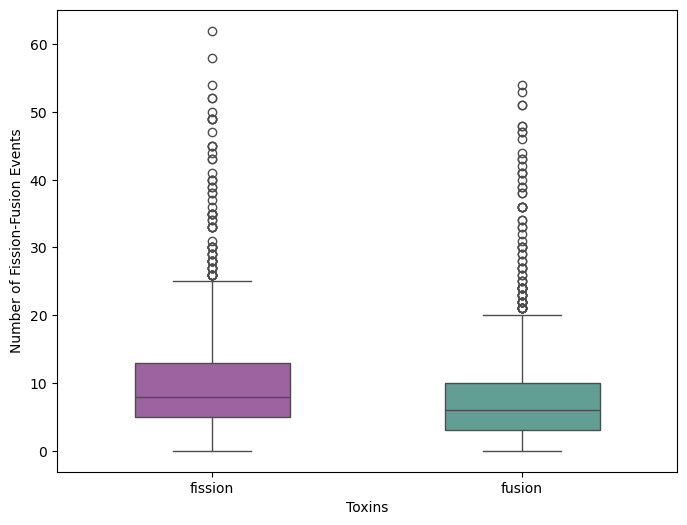

In [57]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='ff', y='event', data=pd.DataFrame({'ff': ['fission'] * len(fission_event) + ['fusion'] * len(fusion_event), 
                                                       'event': np.concatenate([fission_event, fusion_event])}), 
                 palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="Number of Fission-Fusion Events")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
#plt.title("Fission events of different toxin")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\2464517674.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  vp = sns.violinplot(


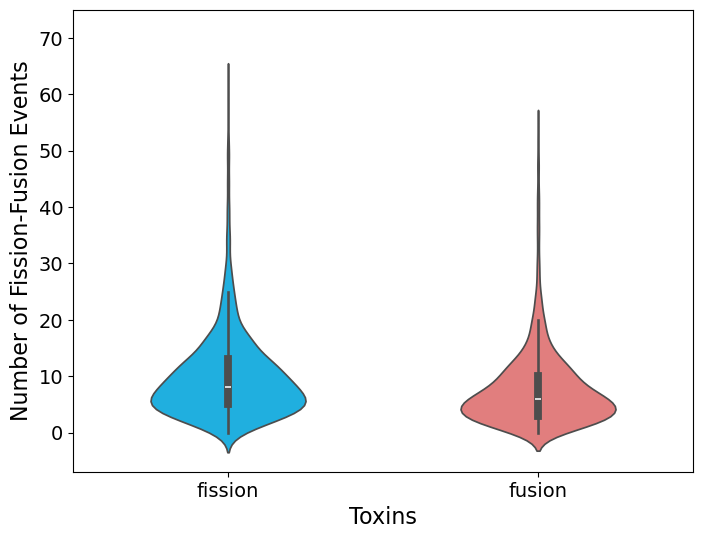

In [130]:
# Prepare DataFrame
data = pd.DataFrame({
    'ff': ['fission'] * len(fission_event) + ['fusion'] * len(fusion_event), 
    'event': np.concatenate([fission_event, fusion_event])
})

# Define colors for violins
colors = ['#00bfff', '#f26d6d']

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Create violin plot
vp = sns.violinplot(
    x='ff', y='event', data=data, 
    palette=colors, ax=ax, width=0.5, inner='box'
)

# Optionally overlay data points (uncomment if desired)
# sns.swarmplot(x='ff', y='event', data=data, color='#e7298a', ax=ax, alpha=0.5, marker='D')

ax.set_xlabel("Toxins", fontsize=16)  # Increase font size for x-axis label
ax.set_ylabel("Number of Fission-Fusion Events", fontsize=16)

# Set axis ticks
ax.tick_params(axis='x', bottom=True, labelsize =14)
ax.tick_params(axis='y', left=True, labelsize =14)

plt.ylim(top = 75)
# Show plot
plt.show()

#### fission toxin normalized by control

In [58]:
# Filter the data for each toxin
control_events = fission_tox_pd[fission_tox_pd['toxin'] == 'control']['event'].values
FCCP_events = fission_tox_pd[fission_tox_pd['toxin'] == 'FCCP']['event'].values
oligomycin_events = fission_tox_pd[fission_tox_pd['toxin'] == 'oligomycin']['event'].values
rotenone_events = fission_tox_pd[fission_tox_pd['toxin'] == 'rotenone']['event'].values

# Perform the division
FCCP_div_control = FCCP_events / control_events
oligomycin_div_control = oligomycin_events / control_events
rotenone_div_control = rotenone_events / control_events

# Create a new DataFrame
toxins = ['FCCP', 'oligomycin', 'rotenone']
data = {
    'toxin': np.repeat(toxins, len(control_events)),
    'event': np.concatenate([FCCP_div_control, oligomycin_div_control, rotenone_div_control])
}
# Replace NaN and inf values with 0
data['event'] = np.nan_to_num(data['event'], nan=0, posinf=0, neginf=0)

# Create the DataFrame
fission_per_control = pd.DataFrame(data)


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1147222747.py:8: RuntimeWarning: invalid value encountered in divide
  FCCP_div_control = FCCP_events / control_events
C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1147222747.py:9: RuntimeWarning: invalid value encountered in divide
  oligomycin_div_control = oligomycin_events / control_events
C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1147222747.py:10: RuntimeWarning: invalid value encountered in divide
  rotenone_div_control = rotenone_events / control_events


In [59]:
print("adjusted fission") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fission_per_control, parametric=False,padjust='holm', effsize = 'r'))

adjusted fission
  Contrast           A           B  Paired  Parametric     U-val alternative  \
0    toxin        FCCP  oligomycin   False       False  113111.0   two-sided   
1    toxin        FCCP    rotenone   False       False  108325.0   two-sided   
2    toxin  oligomycin    rotenone   False       False   81599.0   two-sided   

          p-unc        p-corr p-adjust         r  
0  1.381635e-12  4.144906e-12     holm  0.397256  
1  1.035086e-08  2.070171e-08     holm  0.389363  
2  6.041831e-02  6.041831e-02     holm  0.326440  


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1618143195.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fission_per_control,  palette=colors, ax=ax, width=0.5)
C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1618143195.py:10: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  bp = sns.boxplot(x='toxin', y='event', data=fission_per_control,  palette=colors, ax=ax, width=0.5)


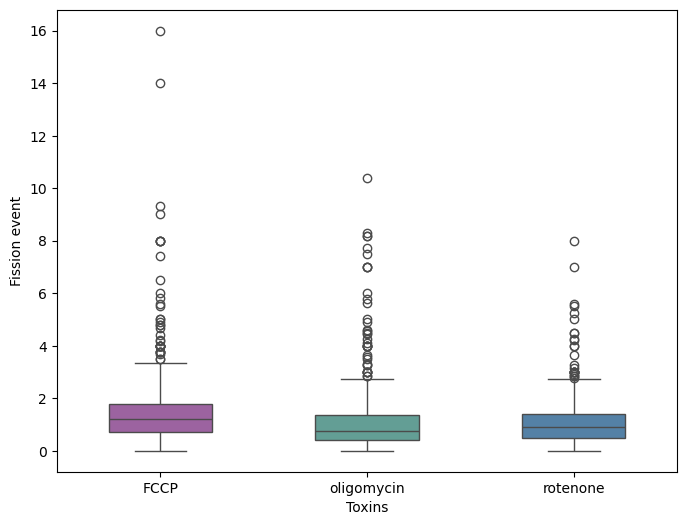

In [60]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fission_per_control,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="Fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
#plt.title("Fission events of different toxin")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

#### fusion toxin normalized by control

In [61]:
# Filter the data for each toxin
control_events = fusion_tox_pd[fusion_tox_pd['toxin'] == 'control']['event'].values
FCCP_events = fusion_tox_pd[fusion_tox_pd['toxin'] == 'FCCP']['event'].values
oligomycin_events = fusion_tox_pd[fusion_tox_pd['toxin'] == 'oligomycin']['event'].values
rotenone_events = fusion_tox_pd[fusion_tox_pd['toxin'] == 'rotenone']['event'].values

# Perform the division
FCCP_div_control = FCCP_events / control_events
oligomycin_div_control = oligomycin_events / control_events
rotenone_div_control = rotenone_events / control_events

# Create a new DataFrame
toxins = ['FCCP', 'oligomycin', 'rotenone']
data = {
    'toxin': np.repeat(toxins, len(control_events)),
    'event': np.concatenate([FCCP_div_control, oligomycin_div_control, rotenone_div_control])
}
# Replace NaN and inf values with 0
data['event'] = np.nan_to_num(data['event'], nan=0, posinf=0, neginf=0)

# Create the DataFrame
fusion_per_control = pd.DataFrame(data)


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1373326860.py:8: RuntimeWarning: divide by zero encountered in divide
  FCCP_div_control = FCCP_events / control_events
C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1373326860.py:8: RuntimeWarning: invalid value encountered in divide
  FCCP_div_control = FCCP_events / control_events
C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1373326860.py:9: RuntimeWarning: divide by zero encountered in divide
  oligomycin_div_control = oligomycin_events / control_events
C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1373326860.py:9: RuntimeWarning: invalid value encountered in divide
  oligomycin_div_control = oligomycin_events / control_events
C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1373326860.py:10: RuntimeWarning: divide by zero encountered in divide
  rotenone_div_control = rotenone_events / control_events
C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1373326860.py:10: RuntimeWarning: invalid value encountered in divide
  rot

In [62]:
print("adjusted fission") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fusion_per_control, parametric=False,padjust='holm', effsize = 'r'))

adjusted fission
  Contrast           A           B  Paired  Parametric     U-val alternative  \
0    toxin        FCCP  oligomycin   False       False  109596.5   two-sided   
1    toxin        FCCP    rotenone   False       False  105037.5   two-sided   
2    toxin  oligomycin    rotenone   False       False   82833.0   two-sided   

          p-unc        p-corr p-adjust         r  
0  1.145596e-09  3.436788e-09     holm  0.264452  
1  1.662839e-06  3.325679e-06     holm  0.215741  
2  1.267673e-01  1.267673e-01     holm  0.110507  


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\25690064.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fusion_per_control,  palette=colors, ax=ax, width=0.5)
C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\25690064.py:10: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  bp = sns.boxplot(x='toxin', y='event', data=fusion_per_control,  palette=colors, ax=ax, width=0.5)


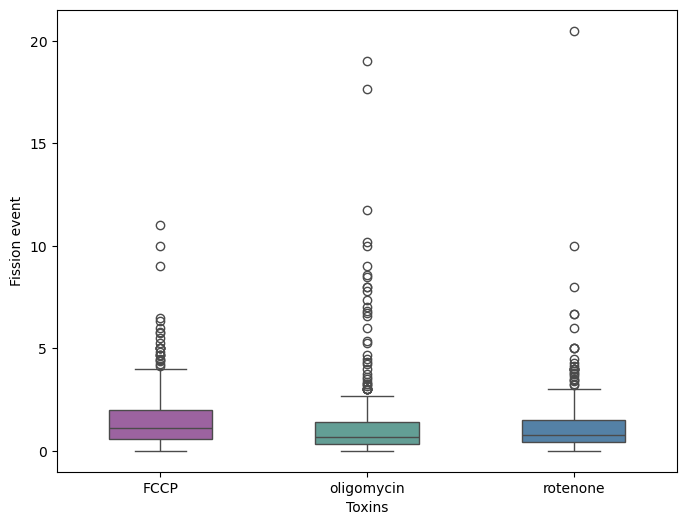

In [63]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fusion_per_control,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="Fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
#plt.title("Fission events of different toxin")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

#### fission, fission/area, fission/label

In [64]:
fission_tox_frame = fission_tox_pd.copy()
fission_tox_area = fission_tox_pd.copy()
fission_tox_frame['event'] = fission_tox_frame['event'] / np.ravel(label_num_all)
fission_tox_area['event'] = fission_tox_area['event'] / np.ravel(area_all)

fusion_tox_frame = fusion_tox_pd.copy()
fusion_tox_area = fusion_tox_pd.copy()
fusion_tox_frame['event'] = fusion_tox_frame['event'] / np.ravel(label_num_all)
fusion_tox_area['event'] = fusion_tox_area['event'] / np.ravel(area_all)

In [65]:
print("adjusted fission") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fission_tox_pd, parametric=False,padjust='holm', effsize = 'r'))

adjusted fission
  Contrast           A           B  Paired  Parametric     U-val alternative  \
0    toxin        FCCP     control   False       False  100181.5   two-sided   
1    toxin        FCCP  oligomycin   False       False  118539.0   two-sided   
2    toxin        FCCP    rotenone   False       False  108739.5   two-sided   
3    toxin     control  oligomycin   False       False  111177.5   two-sided   
4    toxin     control    rotenone   False       False   99701.5   two-sided   
5    toxin  oligomycin    rotenone   False       False   80127.0   two-sided   

          p-unc        p-corr p-adjust         r  
0  6.421938e-04  1.926581e-03     holm  0.295287  
1  5.392154e-18  3.235292e-17     holm -0.008688  
2  4.937084e-09  1.974834e-08     holm  0.244832  
3  5.748671e-11  2.874336e-10     holm  0.023989  
4  1.050690e-03  2.101379e-03     holm  0.417649  
5  2.136518e-02  2.136518e-02     holm  0.054131  


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1417774094.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fission_tox_pd,  palette=colors, ax=ax, width=0.5)


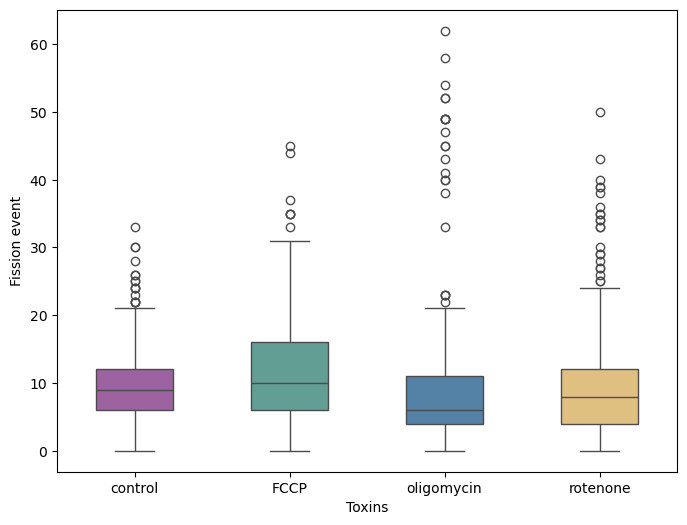

In [66]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fission_tox_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="Fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
#plt.title("Fission events of different toxin")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [67]:
print(np.mean(fission_tox_pd[fission_tox_pd['toxin'] == 'control']['event']))
print(np.mean(fission_tox_pd[fission_tox_pd['toxin'] == 'FCCP']['event']))
print(np.mean(fission_tox_pd[fission_tox_pd['toxin'] == 'oligomycin']['event']))
print(np.mean(fission_tox_pd[fission_tox_pd['toxin'] == 'rotenone']['event']))

9.683333333333334
11.795238095238096
8.81904761904762
9.392857142857142


In [68]:
print(np.mean(fission_tox_self_pd[fission_tox_self_pd['toxin'] == 'control']['event']))
print(np.mean(fission_tox_self_pd[fission_tox_self_pd['toxin'] == 'FCCP']['event']))
print(np.mean(fission_tox_self_pd[fission_tox_self_pd['toxin'] == 'oligomycin']['event']))
print(np.mean(fission_tox_self_pd[fission_tox_self_pd['toxin'] == 'rotenone']['event']))

17.47142857142857
30.55952380952381
16.154761904761905
17.68095238095238


In [69]:
normality = pg.normality(data = fission_tox_frame, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fission_tox_frame, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

print("fission") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fission_tox_frame, parametric=False,padjust='holm', effsize = 'r'))

                   W          pval  normal
toxin                                     
control     0.965474  2.194442e-08   False
FCCP        0.822094  3.161995e-21   False
oligomycin  0.769560  7.504933e-24   False
rotenone    0.931300  5.584920e-13   False
               W      pval  equal_var
levene  4.705098  0.002824      False
fission
  Contrast           A           B  Paired  Parametric     U-val alternative  \
0    toxin        FCCP     control   False       False   52082.5   two-sided   
1    toxin        FCCP  oligomycin   False       False   80151.0   two-sided   
2    toxin        FCCP    rotenone   False       False   72079.0   two-sided   
3    toxin     control  oligomycin   False       False  121240.0   two-sided   
4    toxin     control    rotenone   False       False  105227.0   two-sided   
5    toxin  oligomycin    rotenone   False       False   77352.5   two-sided   

          p-unc        p-corr p-adjust         r  
0  9.418868e-25  5.651321e-24     holm  0.1103

C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1763267985.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fission_tox_frame,  palette=colors, ax=ax, width=0.5)


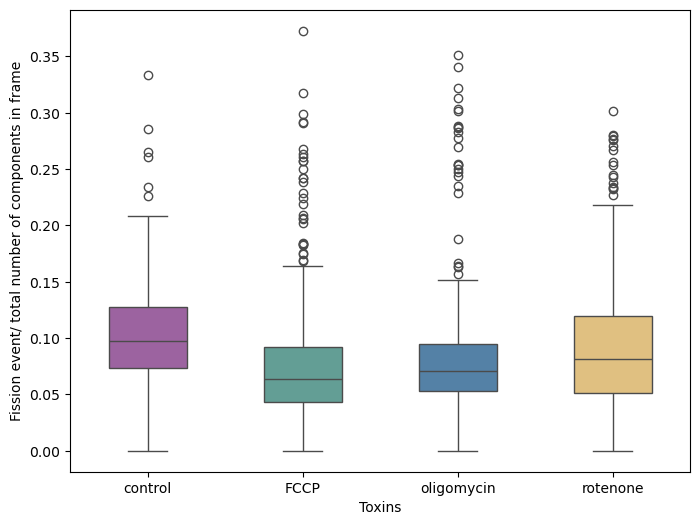

In [70]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fission_tox_frame,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="Fission event/ total number of components in frame")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
#plt.title("fission event per all label for different toxin")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [71]:
normality = pg.normality(data = fission_tox_area, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fission_tox_area, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

print("fission") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fission_tox_area, parametric=False,padjust='holm', effsize = 'r'))

                   W          pval  normal
toxin                                     
control     0.959623  2.491360e-09   False
FCCP        0.923867  9.177202e-14   False
oligomycin  0.765481  4.914224e-24   False
rotenone    0.860825  6.906652e-19   False
               W          pval  equal_var
levene  81.88769  1.947383e-49      False
fission
  Contrast           A           B  Paired  Parametric     U-val alternative  \
0    toxin        FCCP     control   False       False  136870.0   two-sided   
1    toxin        FCCP  oligomycin   False       False  124319.0   two-sided   
2    toxin        FCCP    rotenone   False       False  124727.5   two-sided   
3    toxin     control  oligomycin   False       False   77279.0   two-sided   
4    toxin     control    rotenone   False       False   75907.5   two-sided   
5    toxin  oligomycin    rotenone   False       False   87019.0   two-sided   

          p-unc        p-corr p-adjust         r  
0  1.421001e-43  8.526004e-43     holm

C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\265256498.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fission_tox_area,  palette=colors, ax=ax, width=0.5)


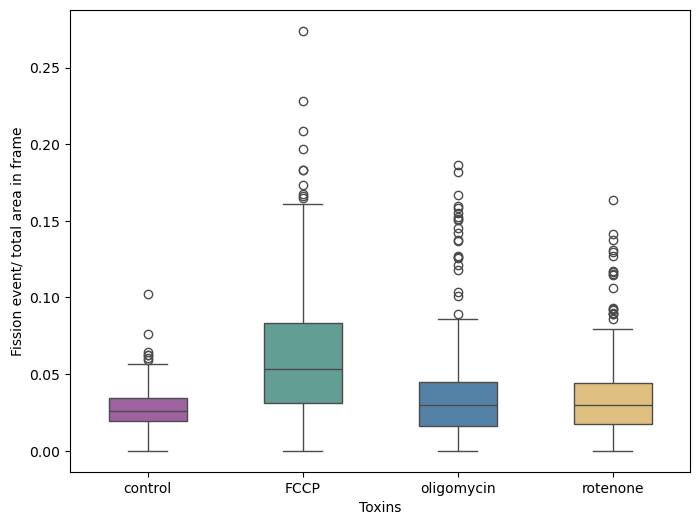

In [72]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fission_tox_area,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="Fission event/ total area in frame")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
#plt.title("fission event per all label for different toxin")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1856798172.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  vp = sns.violinplot(


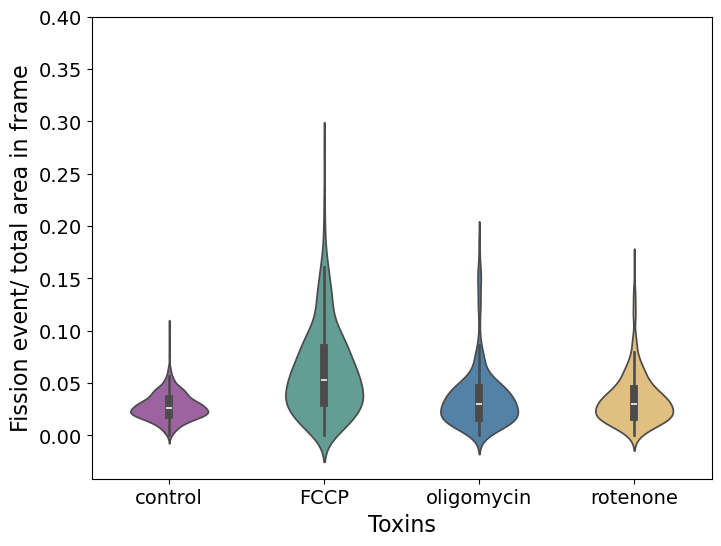

In [131]:
# Define colors for violins
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Create violin plot
vp = sns.violinplot(
    x='toxin', y='event', data=fission_tox_area,
    palette=colors, ax=ax, width=0.5, inner='box'
)

# Optionally overlay data points (uncomment if desired)
# sns.swarmplot(x='ff', y='event', data=data, Acolor='#e7298a', ax=ax, alpha=0.5, marker='D')


ax.set_xlabel("Toxins", fontsize=16)  # Increase font size for x-axis label
ax.set_ylabel("Fission event/ total area in frame", fontsize=16)

# Set axis ticks
ax.tick_params(axis='x', bottom=True, labelsize =14)
ax.tick_params(axis='y', left=True,  labelsize =14)

plt.ylim(top = 0.4)
# Show plot
plt.show()

#### fusion, fusion/area, fusion/all label

In [73]:
print("fusion") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fusion_tox_pd, parametric=False,padjust='holm', effsize = 'r'))

fusion
  Contrast           A           B  Paired  Parametric     U-val alternative  \
0    toxin        FCCP     control   False       False   96801.0   two-sided   
1    toxin        FCCP  oligomycin   False       False  114034.5   two-sided   
2    toxin        FCCP    rotenone   False       False  106434.5   two-sided   
3    toxin     control  oligomycin   False       False  110740.0   two-sided   
4    toxin     control    rotenone   False       False  101098.5   two-sided   
5    toxin  oligomycin    rotenone   False       False   81332.5   two-sided   

          p-unc        p-corr p-adjust         r  
0  1.422262e-02  2.844523e-02     holm  0.241925  
1  1.761029e-13  1.056618e-12     holm  0.044707  
2  2.034424e-07  8.137696e-07     holm  0.166662  
3  1.270834e-10  6.354172e-10     holm  0.035397  
4  2.351946e-04  7.055839e-04     holm  0.360172  
5  5.003601e-02  5.003601e-02     holm -0.004702  


In [74]:
print(np.mean(fusion_tox_pd[fusion_tox_pd['toxin'] == 'control']['event']))
print(np.mean(fusion_tox_pd[fusion_tox_pd['toxin'] == 'FCCP']['event']))
print(np.mean(fusion_tox_pd[fusion_tox_pd['toxin'] == 'oligomycin']['event']))
print(np.mean(fusion_tox_pd[fusion_tox_pd['toxin'] == 'rotenone']['event']))

7.521428571428571
9.226190476190476
7.088095238095238
7.380952380952381


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\122143147.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_pd,  palette=colors, ax=ax, width=0.5)


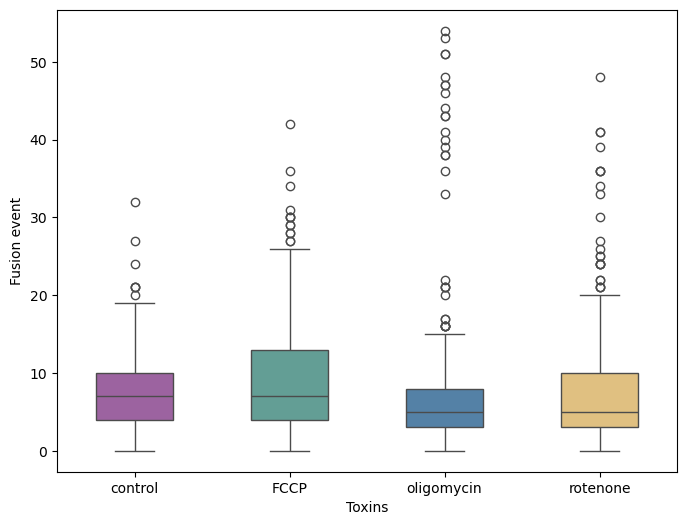

In [75]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="Fusion event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
#plt.title("fusion event per all label for different toxins")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [76]:
normality = pg.normality(data = fusion_tox_frame, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fusion_tox_frame, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)


                   W          pval  normal
toxin                                     
control     0.926702  1.800463e-13   False
FCCP        0.814984  1.297117e-21   False
oligomycin  0.699159  9.994475e-27   False
rotenone    0.904763  1.460868e-15   False
               W      pval  equal_var
levene  4.225307  0.005504      False


In [77]:
print("fusion / all label") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fusion_tox_frame, parametric=False, padjust='holm',effsize = 'r'))

fusion / all label
  Contrast           A           B  Paired  Parametric     U-val alternative  \
0    toxin        FCCP     control   False       False   58415.0   two-sided   
1    toxin        FCCP  oligomycin   False       False   82786.0   two-sided   
2    toxin        FCCP    rotenone   False       False   75597.5   two-sided   
3    toxin     control  oligomycin   False       False  117170.0   two-sided   
4    toxin     control    rotenone   False       False  102745.5   two-sided   
5    toxin  oligomycin    rotenone   False       False   78277.0   two-sided   

          p-unc        p-corr p-adjust         r  
0  2.431463e-17  1.458878e-16     holm  0.104582  
1  1.236382e-01  1.236382e-01     holm  0.115526  
2  3.380565e-04  1.014169e-03     holm  0.010135  
3  1.731667e-16  8.658336e-16     holm  0.053116  
4  3.521079e-05  1.408432e-04     holm  0.057255  
5  4.769864e-03  9.539727e-03     holm -0.011927  


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\2183146739.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_frame,  palette=colors, ax=ax, width=0.5)


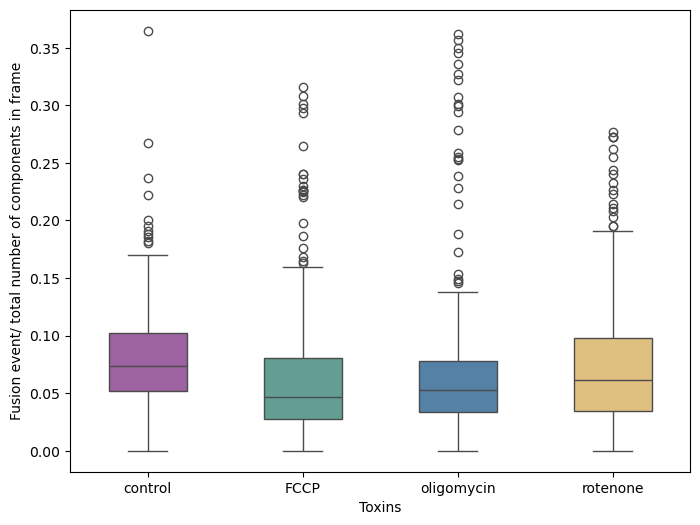

In [78]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_frame,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="Fusion event/ total number of components in frame")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
#plt.title("fission event per all label for different toxins")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [79]:
normality = pg.normality(data = fusion_tox_area, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fusion_tox_area, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

print("fission") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fusion_tox_area, parametric=False,padjust='holm', effsize = 'r'))

                   W          pval  normal
toxin                                     
control     0.967874  5.707926e-08   False
FCCP        0.922285  6.347680e-14   False
oligomycin  0.854646  2.729353e-19   False
rotenone    0.922178  6.191899e-14   False
                W          pval  equal_var
levene  75.356554  1.008255e-45      False
fission
  Contrast           A           B  Paired  Parametric     U-val alternative  \
0    toxin        FCCP     control   False       False  131411.0   two-sided   
1    toxin        FCCP  oligomycin   False       False  120597.0   two-sided   
2    toxin        FCCP    rotenone   False       False  120267.5   two-sided   
3    toxin     control  oligomycin   False       False   78375.0   two-sided   
4    toxin     control    rotenone   False       False   77693.0   two-sided   
5    toxin  oligomycin    rotenone   False       False   86936.5   two-sided   

          p-unc        p-corr p-adjust         r  
0  1.030937e-34  6.185622e-34     ho

C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1587625549.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_area,  palette=colors, ax=ax, width=0.5)


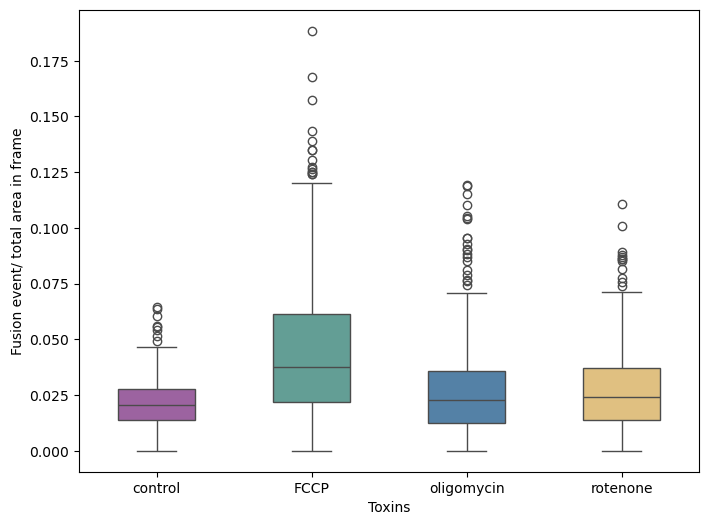

In [80]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_area,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="Fusion event/ total area in frame")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
#plt.title("Fusion event/ total area in frame")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

#### self_fission, fission/area, fission/label

In [81]:
fission_tox_self_frame = fission_tox_self_pd.copy()
fission_tox_self_area = fission_tox_self_pd.copy()
fission_tox_self_frame['event'] = fission_tox_self_frame['event'] / np.ravel(label_num_all)
fission_tox_self_area['event'] = fission_tox_self_area['event'] / np.ravel(area_all)

fusion_tox_self_frame = fusion_tox_self_pd.copy()
fusion_tox_self_area = fusion_tox_self_pd.copy()
fusion_tox_self_frame['event'] = fusion_tox_self_frame['event'] / np.ravel(label_num_all)
fusion_tox_self_area['event'] = fusion_tox_self_area['event'] / np.ravel(area_all)

In [82]:
print("fission all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fission_tox_self_pd, parametric=False,padjust='holm', effsize = 'r'))

fission all
  Contrast           A           B  Paired  Parametric     U-val alternative  \
0    toxin        FCCP     control   False       False  132695.0   two-sided   
1    toxin        FCCP  oligomycin   False       False  140184.0   two-sided   
2    toxin        FCCP    rotenone   False       False  129504.0   two-sided   
3    toxin     control  oligomycin   False       False  100861.0   two-sided   
4    toxin     control    rotenone   False       False   88393.5   two-sided   
5    toxin  oligomycin    rotenone   False       False   78712.0   two-sided   

          p-unc        p-corr p-adjust         r  
0  9.668429e-37  4.834215e-36     holm  0.549700  
1  1.658151e-49  9.948905e-49     holm -0.217940  
2  6.885323e-32  2.754129e-31     holm  0.605882  
3  3.130006e-04  9.390018e-04     holm  0.222166  
4  9.561954e-01  9.561954e-01     holm  0.711957  
5  6.925016e-03  1.385003e-02     holm  0.267830  


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\2075197304.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fission_tox_self_pd,  palette=colors, ax=ax, width=0.5)


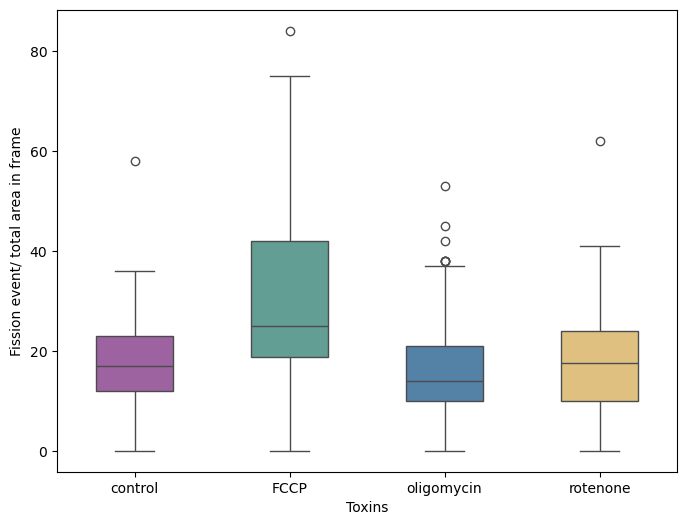

In [83]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fission_tox_self_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="Fission event/ total area in frame")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
#plt.title("fission events for different glucose concentration")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [84]:
print("fission all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fission_tox_self_frame, parametric=False,padjust='holm', effsize = 'r'))

fission all
  Contrast           A           B  Paired  Parametric     U-val alternative  \
0    toxin        FCCP     control   False       False   83225.0   two-sided   
1    toxin        FCCP  oligomycin   False       False  107641.5   two-sided   
2    toxin        FCCP    rotenone   False       False   93730.0   two-sided   
3    toxin     control  oligomycin   False       False  113959.5   two-sided   
4    toxin     control    rotenone   False       False   99788.0   two-sided   
5    toxin  oligomycin    rotenone   False       False   73021.0   two-sided   

          p-unc        p-corr p-adjust         r  
0  1.571272e-01  2.316010e-01     holm  0.245890  
1  3.216318e-08  1.608159e-07     holm  0.224711  
2  1.158005e-01  2.316010e-01     holm  0.277894  
3  2.368249e-13  1.420950e-12     holm  0.310360  
4  9.820396e-04  2.946119e-03     holm  0.276557  
5  1.582045e-05  6.328182e-05     holm  0.284382  


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\825809276.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fission_tox_self_frame,  palette=colors, ax=ax, width=0.5)


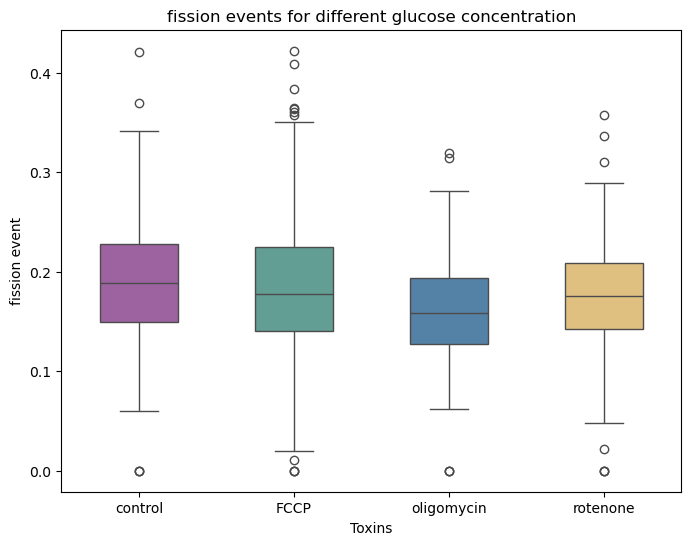

In [85]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fission_tox_self_frame,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission events for different glucose concentration")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [86]:
print("fission all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fission_tox_self_area, parametric=False,padjust='holm', effsize = 'r'))

fission all
  Contrast           A           B  Paired  Parametric     U-val alternative  \
0    toxin        FCCP     control   False       False  157738.5   two-sided   
1    toxin        FCCP  oligomycin   False       False  138925.5   two-sided   
2    toxin        FCCP    rotenone   False       False  144272.5   two-sided   
3    toxin     control  oligomycin   False       False   55828.5   two-sided   
4    toxin     control    rotenone   False       False   44633.5   two-sided   
5    toxin  oligomycin    rotenone   False       False   93822.5   two-sided   

          p-unc        p-corr p-adjust         r  
0  4.676245e-87  2.805747e-86     holm -0.354020  
1  3.517604e-47  1.407041e-46     holm  0.425722  
2  2.970819e-57  1.485410e-56     holm  0.051071  
3  3.366008e-20  6.732016e-20     holm  0.044153  
4  2.939659e-35  8.818978e-35     holm  0.173434  
5  1.098322e-01  1.098322e-01     holm  0.170188  


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\2024252475.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fission_tox_self_area,  palette=colors, ax=ax, width=0.5)


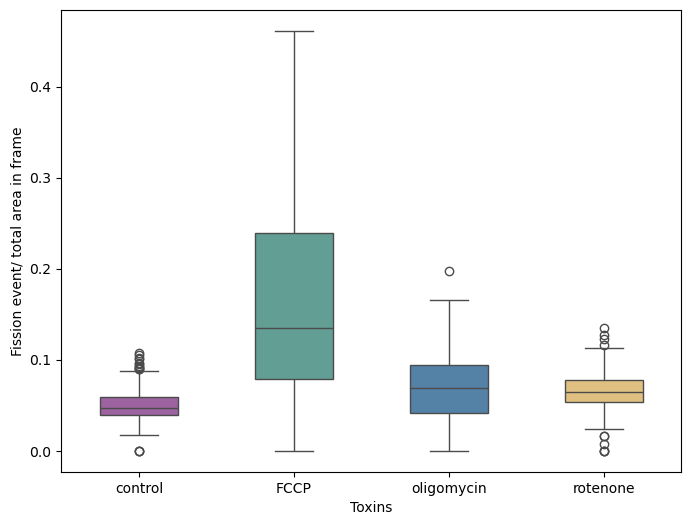

In [87]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fission_tox_self_area,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="Fission event/ total area in frame")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
#plt.title("fission events for different glucose concentration")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\754976586.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  vp = sns.violinplot(


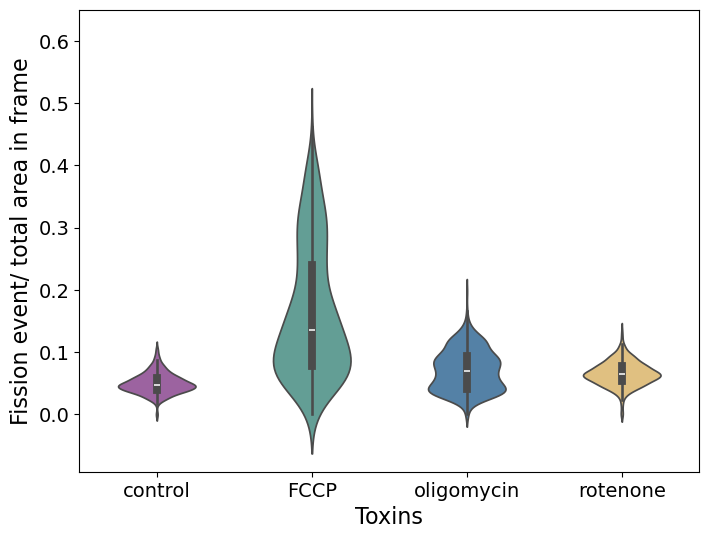

In [132]:
# Define colors for violins
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Create violin plot
vp = sns.violinplot(
    x='toxin', y='event', data=fission_tox_self_area,
    palette=colors, ax=ax, width=0.5, inner='box'
)

# Optionally overlay data points (uncomment if desired)
# sns.swarmplot(x='ff', y='event', data=data, Acolor='#e7298a', ax=ax, alpha=0.5, marker='D')

ax.set_xlabel(xlabel="Toxins", fontsize=16)  # Increase font size for x-axis label
ax.set_ylabel( ylabel="Fission event/ total area in frame", fontsize=16)


# Set axis ticks
ax.tick_params(axis='x', bottom=True, labelsize =14)
ax.tick_params(axis='y', left=True, labelsize =14)
plt.ylim(top=0.65)
# Show plot
plt.show()

#### self fusion, fusion/area, fusion/label

In [88]:
print("fusion all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fusion_tox_self_pd, parametric=False,padjust='holm', effsize = 'r'))

fusion all
  Contrast           A           B  Paired  Parametric     U-val alternative  \
0    toxin        FCCP     control   False       False  131426.5   two-sided   
1    toxin        FCCP  oligomycin   False       False  138537.5   two-sided   
2    toxin        FCCP    rotenone   False       False  127067.5   two-sided   
3    toxin     control  oligomycin   False       False   99410.0   two-sided   
4    toxin     control    rotenone   False       False   86780.0   two-sided   
5    toxin  oligomycin    rotenone   False       False   78777.0   two-sided   

          p-unc        p-corr p-adjust         r  
0  8.801009e-35  4.400505e-34     holm  0.546570  
1  1.509771e-46  9.058625e-46     holm -0.192318  
2  1.956293e-28  7.825173e-28     holm  0.656102  
3  1.412046e-03  4.236137e-03     holm  0.242345  
4  6.861698e-01  6.861698e-01     holm  0.728231  
5  7.307893e-03  1.461579e-02     holm  0.205045  


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\3023877250.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_self_pd,  palette=colors, ax=ax, width=0.5)


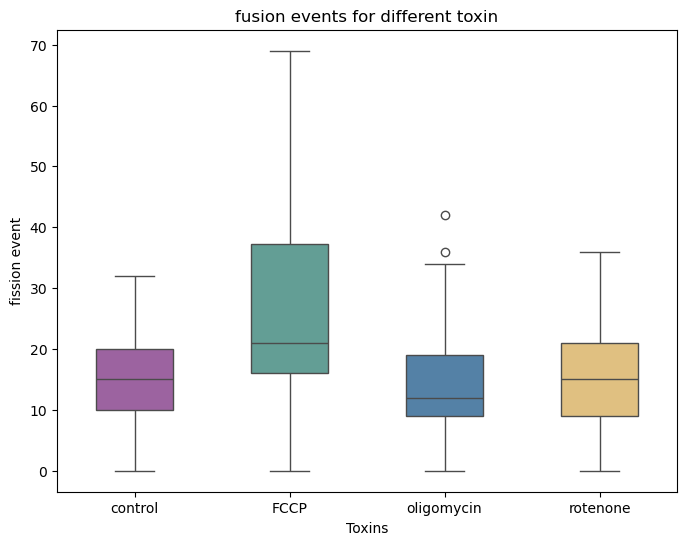

In [89]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_self_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fusion events for different toxin")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [90]:
print("fission all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fusion_tox_self_frame, parametric=False,padjust='holm', effsize = 'r'))

fission all
  Contrast           A           B  Paired  Parametric     U-val alternative  \
0    toxin        FCCP     control   False       False   81333.0   two-sided   
1    toxin        FCCP  oligomycin   False       False  103470.0   two-sided   
2    toxin        FCCP    rotenone   False       False   89876.0   two-sided   
3    toxin     control  oligomycin   False       False  110429.5   two-sided   
4    toxin     control    rotenone   False       False   97303.5   two-sided   
5    toxin  oligomycin    rotenone   False       False   74238.5   two-sided   

          p-unc        p-corr p-adjust         r  
0  5.082998e-02  1.016600e-01     holm  0.299689  
1  1.406597e-05  7.032983e-05     holm  0.324263  
2  6.336955e-01  6.336955e-01     holm  0.360283  
3  2.578438e-10  1.547063e-09     holm  0.286350  
4  9.625272e-03  2.887582e-02     holm  0.360838  
5  7.166471e-05  2.866588e-04     holm  0.348513  


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1418994366.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_self_frame,  palette=colors, ax=ax, width=0.5)


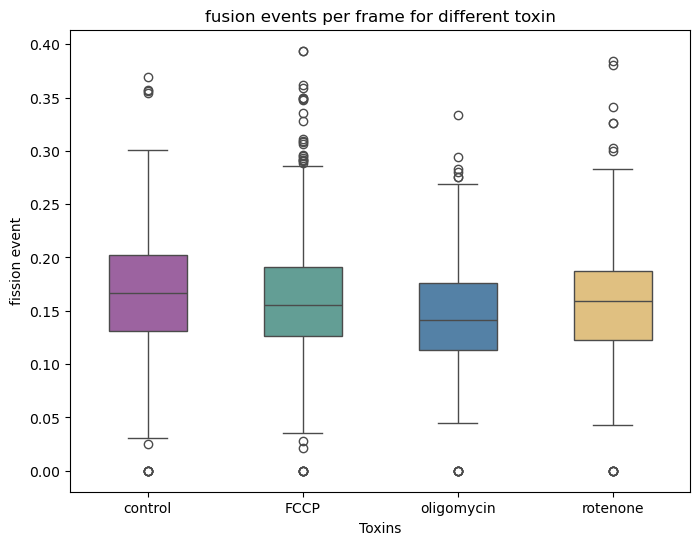

In [91]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_self_frame,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fusion events per frame for different toxin")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [92]:
print("fission all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fusion_tox_self_area, parametric=False,padjust='holm', effsize = 'r'))

fission all
  Contrast           A           B  Paired  Parametric     U-val alternative  \
0    toxin        FCCP     control   False       False  156499.0   two-sided   
1    toxin        FCCP  oligomycin   False       False  137318.5   two-sided   
2    toxin        FCCP    rotenone   False       False  141254.0   two-sided   
3    toxin     control  oligomycin   False       False   53653.0   two-sided   
4    toxin     control    rotenone   False       False   43232.5   two-sided   
5    toxin  oligomycin    rotenone   False       False   93487.0   two-sided   

          p-unc        p-corr p-adjust         r  
0  4.768293e-84  2.860976e-83     holm -0.316506  
1  2.388925e-44  9.555701e-44     holm  0.494120  
2  1.915674e-51  9.578371e-51     holm  0.163205  
3  8.756950e-23  1.751390e-22     holm  0.026739  
4  1.887962e-37  5.663887e-37     holm  0.145818  
5  1.327023e-01  1.327023e-01     holm  0.117905  


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\2479169777.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_self_area,  palette=colors, ax=ax, width=0.5)


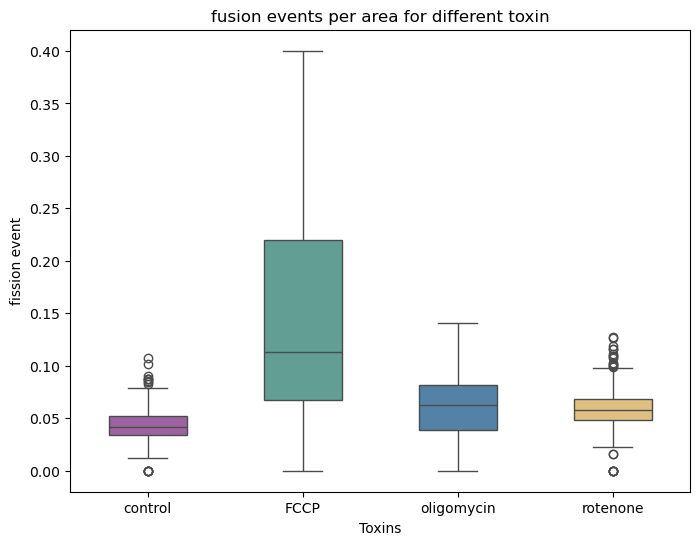

In [93]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_self_area,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fusion events per area for different toxin")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

#### fission fusion from nellie

In [94]:
fission_tox_nellie_frame = fission_tox_nellie.copy()
fission_tox_nellie_area = fission_tox_nellie.copy()
fission_tox_nellie_frame['event'] = fission_tox_nellie_frame['event'] / np.ravel(label_num_all)
fission_tox_nellie_area['event'] = fission_tox_nellie_area['event'] / np.ravel(area_all)

fusion_tox_nellie_frame = fusion_tox_nellie.copy()
fusion_tox_nellie_area = fusion_tox_nellie.copy()
fusion_tox_nellie_frame['event'] = fusion_tox_nellie_frame['event'] / np.ravel(label_num_all)
fusion_tox_nellie_area['event'] = fusion_tox_nellie_area['event'] / np.ravel(area_all)

In [95]:
print("fission nellie") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fission_tox_nellie_area, parametric=False,padjust='holm', effsize = 'r'))

fission nellie
  Contrast           A           B  Paired  Parametric    U-val alternative  \
0    toxin        FCCP     control   False       False  99129.0   two-sided   
1    toxin        FCCP  oligomycin   False       False  96719.0   two-sided   
2    toxin        FCCP    rotenone   False       False  96137.0   two-sided   
3    toxin     control  oligomycin   False       False  84759.0   two-sided   
4    toxin     control    rotenone   False       False  84951.0   two-sided   
5    toxin  oligomycin    rotenone   False       False  88188.0   two-sided   

      p-unc    p-corr p-adjust         r  
0  0.000815  0.004891     holm -0.040943  
1  0.009148  0.045738     holm -0.039767  
2  0.015766  0.063063     holm -0.013510  
3  0.289754  0.869262     holm -0.003941  
4  0.320499  0.869262     holm  0.050615  
5  0.997197  0.997197     holm  0.067818  


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\1718751446.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fission_tox_nellie_area,  palette=colors, ax=ax, width=0.5)


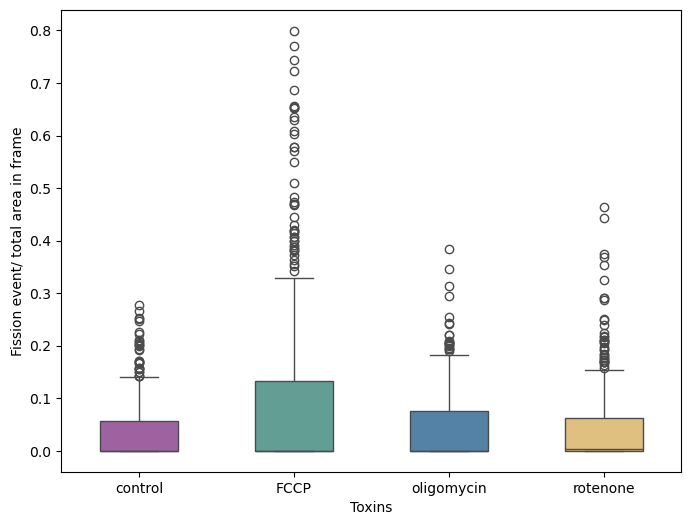

In [96]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fission_tox_nellie_area,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="Fission event/ total area in frame")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
#plt.title("Fission event/ total area in frame")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\4154516760.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  vp = sns.violinplot(


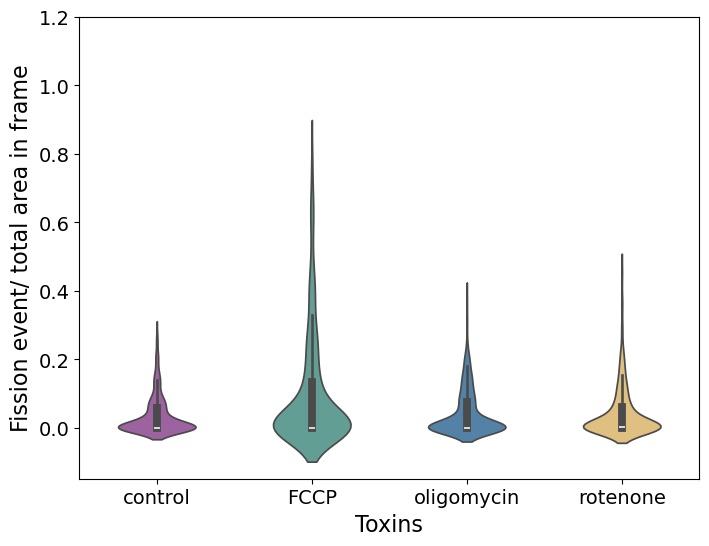

In [134]:
# Define colors for violins
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Create violin plot
vp = sns.violinplot(
    x='toxin', y='event', data=fission_tox_nellie_area,
    palette=colors, ax=ax, width=0.5, inner='box'
)

# Optionally overlay data points (uncomment if desired)
# sns.swarmplot(x='ff', y='event', data=data, Acolor='#e7298a', ax=ax, alpha=0.5, marker='D')

ax.set_xlabel(xlabel="Toxins", fontsize= 16)
ax.set_ylabel(ylabel="Fission event/ total area in frame", fontsize= 16)

# Set axis ticks
ax.tick_params(axis='x', bottom=True, labelsize =14)
ax.tick_params(axis='y', left=True, labelsize =14)

# Show plot
plt.ylim(top  =1.2)
plt.show()

In [97]:
print("fusion nellie") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fusion_tox_nellie, parametric=False,padjust='holm', effsize = 'r'))

fusion nellie
  Contrast           A           B  Paired  Parametric    U-val alternative  \
0    toxin        FCCP     control   False       False  88635.0   two-sided   
1    toxin        FCCP  oligomycin   False       False  90790.0   two-sided   
2    toxin        FCCP    rotenone   False       False  92931.0   two-sided   
3    toxin     control  oligomycin   False       False  90838.5   two-sided   
4    toxin     control    rotenone   False       False  93288.0   two-sided   
5    toxin  oligomycin    rotenone   False       False  90657.0   two-sided   

      p-unc    p-corr p-adjust         r  
0  0.894569  1.000000     holm  0.022003  
1  0.427896  1.000000     holm -0.019747  
2  0.144547  0.722734     holm  0.071375  
3  0.422724  1.000000     holm  0.057548  
4  0.119531  0.717188     holm  0.071378  
5  0.450479  1.000000     holm  0.055124  


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\2647550730.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_nellie,  palette=colors, ax=ax, width=0.5)


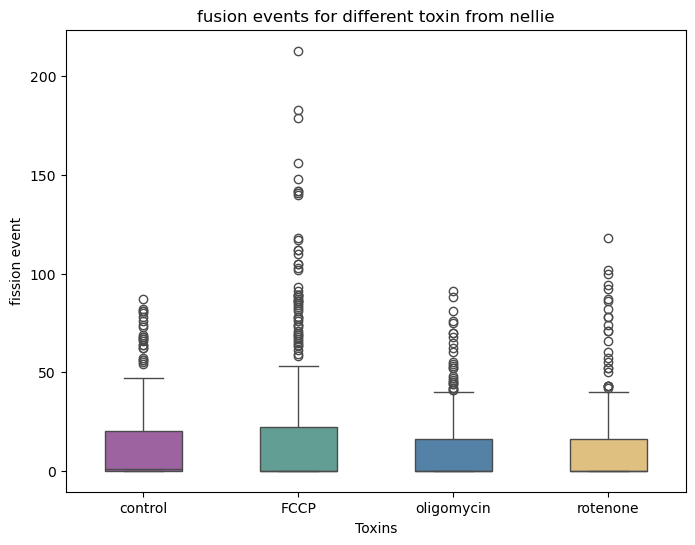

In [98]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_nellie,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fusion events for different toxin from nellie")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

#### fission / fusion ratio

In [99]:
print("fission fusion ratio") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = ff_ratio_log_pd, parametric=False,padjust='holm', effsize = 'r'))

fission fusion ratio
  Contrast           A           B  Paired  Parametric    U-val alternative  \
0    toxin        FCCP     control   False       False  90227.0   two-sided   
1    toxin        FCCP  oligomycin   False       False  89329.5   two-sided   
2    toxin        FCCP    rotenone   False       False  88837.5   two-sided   
3    toxin     control  oligomycin   False       False  87051.0   two-sided   
4    toxin     control    rotenone   False       False  86479.5   two-sided   
5    toxin  oligomycin    rotenone   False       False  87255.5   two-sided   

      p-unc  p-corr p-adjust         r  
0  0.564309     1.0     holm  0.114705  
1  0.748071     1.0     holm  0.056734  
2  0.856219     1.0     holm  0.044314  
3  0.743801     1.0     holm  0.070359  
4  0.624624     1.0     holm  0.065893  
5  0.788253     1.0     holm -0.001801  


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\2046947918.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=ff_ratio_log_pd,  palette=colors, ax=ax, width=0.5)


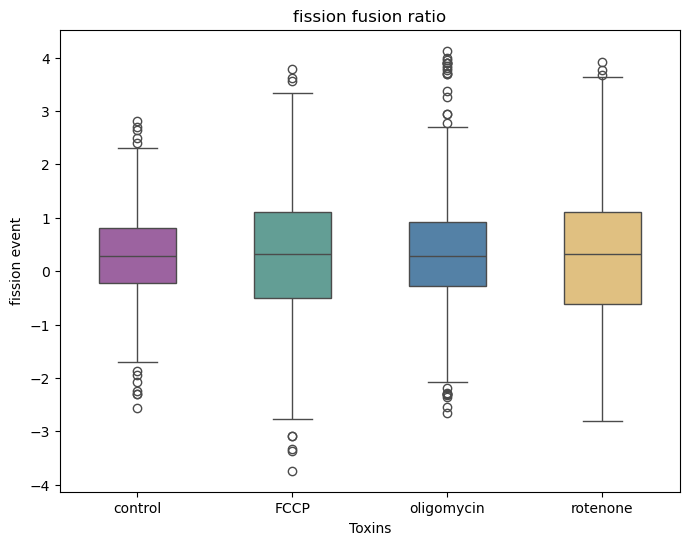

In [100]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=ff_ratio_log_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission fusion ratio")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [101]:
print("fission fusion ratio adjusted") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = ff_ratio_all_log_pd, parametric=False,padjust='holm', effsize = 'r'))

fission fusion ratio adjusted
  Contrast           A           B  Paired  Parametric    U-val alternative  \
0    toxin        FCCP     control   False       False  88500.5   two-sided   
1    toxin        FCCP  oligomycin   False       False  90617.0   two-sided   
2    toxin        FCCP    rotenone   False       False  89278.5   two-sided   
3    toxin     control  oligomycin   False       False  90851.0   two-sided   
4    toxin     control    rotenone   False       False  89039.0   two-sided   
5    toxin  oligomycin    rotenone   False       False  86847.5   two-sided   

      p-unc  p-corr p-adjust         r  
0  0.932003     1.0     holm  0.053061  
1  0.491897     1.0     holm  0.028473  
2  0.759150     1.0     holm  0.006629  
3  0.450909     1.0     holm -0.002969  
4  0.811501     1.0     holm  0.020851  
5  0.700573     1.0     holm  0.061346  


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\3054310294.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=ff_ratio_all_log_pd,  palette=colors, ax=ax, width=0.5)


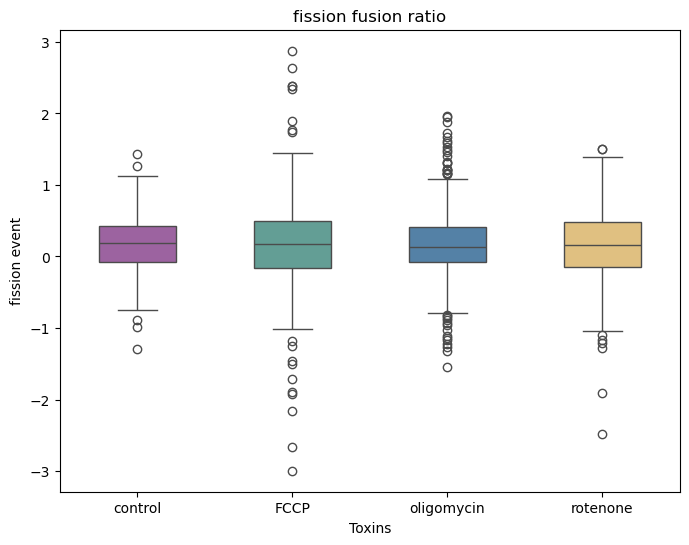

In [102]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=ff_ratio_all_log_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission fusion ratio")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [103]:
print("fission fusion ratio all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = ff_ratio_self_pd, parametric=False, padjust='holm' ,effsize = 'r' ))

fission fusion ratio all
  Contrast           A           B  Paired  Parametric    U-val alternative  \
0    toxin        FCCP     control   False       False  90622.0   two-sided   
1    toxin        FCCP  oligomycin   False       False  92057.5   two-sided   
2    toxin        FCCP    rotenone   False       False  92313.0   two-sided   
3    toxin     control  oligomycin   False       False  89627.5   two-sided   
4    toxin     control    rotenone   False       False  89846.0   two-sided   
5    toxin  oligomycin    rotenone   False       False  88287.5   two-sided   

      p-unc  p-corr p-adjust         r  
0  0.490978     1.0     holm  0.917639  
1  0.272606     1.0     holm  0.665028  
2  0.242097     1.0     holm  0.918165  
3  0.684789     1.0     holm  0.800424  
4  0.639716     1.0     holm  0.950050  
5  0.980254     1.0     holm  0.756299  


C:\Users\iceji\AppData\Local\Temp\ipykernel_6364\191875566.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=ff_ratio_self_pd,  palette=colors, ax=ax, width=0.5)


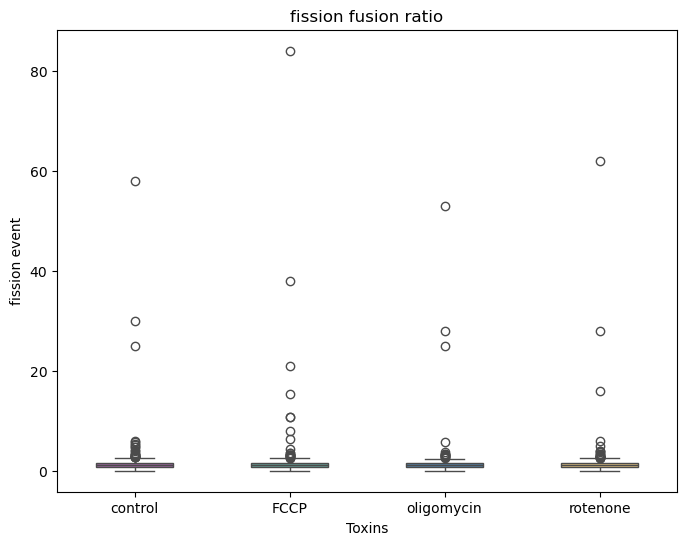

In [104]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=ff_ratio_self_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission fusion ratio")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()